# Machine Sommelier 工作機械ソムリエ by moriitkys (2020/06/29)
はじめてResNetやMobilenetをimagenetなどのweightsありで使う場合、インターネットにつないでおく必要があります。You should connect to the internet for downloading initial weights

### Notice   
 - デフォルトではResNet50を用いたInferenceモード（学習済みモデルを使った推測）です。The default is "Inference" mode using "ResNet50" (inference using pre-trained model).
 - 学習用データセットが1万を超える程度の場合、セル1の実行には時間がかかります。If you have more than 10,000 training datasets, cell 1 will take a long time to run.
 - データセットは1_0001.jpgのように、クラスナンバー_000x.jpg(png...)という形式で用意します。テストデータも同じです。プログラム内ではファイル名の0番目をその画像の正解ラベルとして取得します。プログラム上、正解クラス番号から１を引いた数が格納されます。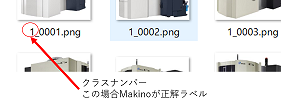
 - セル1を実行すると数秒後に設定選択用のウィンドウが表示されるので、学習の実行にはTrainを選択、Mobilenetの選択にはラジオボタンをチェックしてStartを押してください。その後は最後までセルを順に実行してください。When you execute cell 1, a window for setting selection will be displayed after a few seconds, so select "Train" to execute learning, check the radio button to select "Mobilenet", and press "Start". After that, execute the cells in order until the end.
 - GTX1060 6GBありで、学習には30epochでResNetは約1時間、Mobilenetは約30分かかります。
 - テストの実行　plobs_pred = model.predict(input_tests)のように学習済みのモデルでのテスト画像の推測を実行する場合、testフォルダーに画像をいれて推測してください。また重みファイルのhdf5ファイルは10エポックごとに保存されますが、最後に保存された重みが採用されます。Executing the test If you want to infer the test image in the trained model like plobs_pred = model.predict(input_tests), put the image in the test folder and guess. The weight file hdf5 is saved every 10 epochs, but the last saved weight is adopted.

### Splitting the datast   
学習モデルにtrainとvalidationのデータを与える場合、集めたデータセットをtrain:val=5:5でランダムに分割します。したがってこれを実行するごとにtrainとvalは異なるものとなります。データセットを完全に同じにしてネットワークの比較などを行う場合は固定した方がいいと思ったので、今回は一度分割したらその分割の状態をtxtに保存し、次からも使えるようにします。txtが存在しない場合には改めてランダムに分割します。   
ちなみに、ランダムに分割するたびに学習の精度が変わる場合はデータセットに偏りがあるか、エポック数が十分ではないか、何か不備があるはずです。   
When train and validation data are given to the learning model, the collected data set is randomly divided with train:val=5:5. So each time you do this, train and val will be different. I thought that it is better to fix it when comparing the networks with the same data set completely, so this time once I divide it, save the state of that division to txt so that I can use it again. If txt does not exist, it will be randomly divided again.
By the way, if the accuracy of training changes with each random division, the data set may be biased, the number of epochs may not be sufficient, or something may be wrong.

### Parameters
 - categories   
 クラスの名前を列挙したリスト。List of class names to be classified
 - aug_rate   
 データセットを拡張していない場合はこれを使います。ただし、あまり品質のよいものができないので、私の別のプログラムを用いてデータ拡張するのが良いです。You should change variable *aug_rate* if you want to do augmentation (*aug_rate* > 1). if *aug_rate* == 1, don't do augmentation   
 - ratio_train   
 0<*ratio_train*<10であり、学習データ：評価データ＝*ratio_train*:10-*ratio_train*です。
 - epochs   
 データセットを何回学習するか。How many times to train one training data. If your dataset is small, increase the number of epochs.   
 - batch_size   
 一度にモデルへ入力するデータの数。Number of data inputs to the model at one time. If your VRAM is big, increase the number of batch_size(64, 128, ...)   
 - layer.trainable   
 学習する層の定義。今回はすべての層を学習します。COCOやImageNetのweightsを読み込んで転移学習する場合はバックボーンをフリーズして**ヘッドだけ学習するのが普通です**。その場合は以下のようにフリーズする層を指定します。Definition of layers to learn. This time the model will learn all layers.      
 ex. for layer in model.layers[-3:]:
    layer.trainable = True

In [1]:
#Settings and prepare your dataset
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import keras
from keras import layers,models
from keras import optimizers
from keras.utils import np_utils
import keras.backend as K
import keras.layers as KL
import glob
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import random_rotation, random_shift, random_zoom

import PIL
import cv2

flag_train = False
type_backbone = "ResNet50"
layer_name_gradcam = "activation_49"

# --- Setting buttons ---
import tkinter
tki = tkinter.Tk()
tki.geometry('300x400')
tki.title('Settings')

radio_value_aug = tkinter.IntVar() 
radio_value_split = tkinter.IntVar() 
radio_value = tkinter.IntVar() 

label = tkinter.Label(tki, text='Mode: Inference')
label.place(x=50, y=60)

def callback(event):
    if event.widget["bg"] == "SystemButtonFace":
        event.widget["bg"] = "red"
    else:
        event.widget["bg"] = "SystemButtonFace"
        
def click_flag_train():
    global flag_train
    if flag_train == True:
        label['text'] = 'Mode: Inference'
        flag_train = False
    else:
        label['text'] = 'Mode: Train'
        flag_train = True

def click_start():
    tki.destroy()
    
# Create buttons
btn_flag_train = tkinter.Button(tki, text='Train', command = click_flag_train)
btn_start = tkinter.Button(tki, text='Start', command = click_start)
label1 = tkinter.Label(tki,text="1. Select Train or Inference")
label1.place(x=50, y=30)
btn_flag_train.place(x=50, y=100)


label2 = tkinter.Label(tki,text="2. Select ResNet50 or Mobilenet")
label2.place(x=50, y=150)
rdio_one = tkinter.Radiobutton(tki, text='ResNet',
                             variable=radio_value, value=1) 
rdio_two = tkinter.Radiobutton(tki, text='Mobilenet',
                             variable=radio_value, value=2) 
rdio_one.place(x=50, y=180)
rdio_two.place(x=150, y=180)

label3 = tkinter.Label(tki,text="3. Start")
label3.place(x=50, y=250)
btn_start.place(x=50, y=280)

# Display the button window
btn_flag_train.bind("<1>",callback)
btn_start.bind("<1>",callback)
tki.mainloop()

if radio_value.get() == 1:
    type_backbone = "ResNet50"
    layer_name_gradcam = "activation_49"
elif radio_value.get() == 2 :
    type_backbone = "Mobilenet"
    layer_name_gradcam = "conv_pw_13_relu"

print(flag_train)
print(type_backbone)

# --- preparing dataset ---
categories=["Makino", "Okuma", "OKK", "Toshiba", "JTEKT", "Tsugami", "Mitsubishi" ]
nb_classes=len(categories)
img_h, img_w = 197, 197
if type_backbone == "ResNet50":
    img_h, img_w = 197, 197
elif type_backbone == "Mobilenet":
    img_h, img_w = 192, 192
print(img_h, img_w)
aug_rate = 1 # You should change if you want to do augmentation (aug_rate > 1). if aug_rate == 1, don't do augmentation

dirname = "dataset_mt4_2"# dataset folder
x_train, y_train, x_val, y_val = [],[],[],[]

path_train_txt = 'dataset_train.txt'
path_val_txt = 'dataset_val.txt'
ratio_train = 6.0#0.0 ~ 10.0

def train_or_val():
    s_train_or_val = "train"
    rn = random.uniform(0, 10)
    if rn <= ratio_train:
        s_train_or_val = "train"
    elif rn > ratio_train:
        s_train_or_val = "val"
    return s_train_or_val

def prepare_dataset_aug():
    files = glob.glob(dirname + "/*")#file name should be like "1_0001.jpg"
    n = 0
    for imgfile in files:
        img = load_img(imgfile)
        array = img_to_array(img)
        for i in range(aug_rate):
            array_aug = array
            if i > 0:
                array_aug = random_rotation(array_aug, rg=360)
                img_aug = array_to_img(array_aug)
                img_aug.save(imgfile[0:-4]+"_"+str(i)+".png")
        n += 1
        
def prepare_dataset_val():
    files = glob.glob(dirname + "/*")#file name should be like "1_0001.jpg"
    with open(path_train_txt, mode='w') as f1:
        with open(path_val_txt, mode='w') as f2:
            for imgfile in files:
                s_train_or_val = train_or_val()
                if s_train_or_val == "train":
                    f1.write(imgfile+"\n")
                elif s_train_or_val == "val":
                    f2.write(imgfile+"\n")
                    
def prepare_dataset():
    with open(path_train_txt) as f1:#file name should be like "1_0001.jpg"
        for s_line in f1:
            label = s_line.strip(dirname)[1]# No.0 is '/'
            img = load_img(s_line[:-1], target_size=(img_h, img_w))#s_line contains "\n"
            array = img_to_array(img) / 255
            x_train.append(array)
            y_train.append(int(label)-1)
    with open(path_val_txt) as f2:
        for s_line in f2:
            label = s_line.strip(dirname)[1]# No.0 is '/'
            img = load_img(s_line[:-1], target_size=(img_h, img_w))#s_line contains "\n"
            array = img_to_array(img) / 255
            x_val.append(array)
            y_val.append(int(label)-1)
            
if flag_train == True:
    if aug_rate > 1:
        prepare_dataset_aug()
    if os.path.isfile(path_train_txt) == False or os.path.isfile(path_val_txt) == False:
        print("splitting")
        prepare_dataset_val()
    prepare_dataset()
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
                   

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\

True
ResNet50
197 197


In [2]:
# Build a model
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model, load_model, Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, RMSprop, SGD

base_model = Sequential()
top_model = Sequential()
if type_backbone == "ResNet50":
    INPUT_SHAPE = (img_h, img_w, 3)
    base_model = ResNet50(
        include_top = False,
        weights = "imagenet",
        input_shape = INPUT_SHAPE
    )
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))

elif type_backbone == "Mobilenet":
    INPUT_SHAPE = (img_h, img_w, 3)
    base_model = MobileNet(
        include_top = False,
        weights = "imagenet",
        input_shape = INPUT_SHAPE
    )
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))

# Concatenate base_model(backbone) with top model
model = Model(input=base_model.input, output=top_model(base_model.output))

print("{}層".format(len(model.layers)))

# Train All layers
#for layer in model.layers[:-6]:
#    layer.trainable = False
#for layer in base_model.layers:
#    layer.trainable = False

# Compile the model
model.compile(
    optimizer = SGD(lr=0.001),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

model.summary()

176層
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activ

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


Train on 6364 samples, validate on 4328 samples
Epoch 1/30
6364/6364 [==============================] - 138s 22ms/step - loss: 1.3704 - acc: 0.5108 - val_loss: 0.4941 - val_acc: 0.9127
Epoch 2/30
6364/6364 [==============================] - 125s 20ms/step - loss: 0.4803 - acc: 0.8680 - val_loss: 0.2005 - val_acc: 0.9757
Epoch 3/30
6364/6364 [==============================] - 126s 20ms/step - loss: 0.2505 - acc: 0.9475 - val_loss: 0.1052 - val_acc: 0.9889
Epoch 4/30
6364/6364 [==============================] - 126s 20ms/step - loss: 0.1542 - acc: 0.9725 - val_loss: 0.0672 - val_acc: 0.9940
Epoch 5/30
6364/6364 [==============================] - 126s 20ms/step - loss: 0.1045 - acc: 0.9840 - val_loss: 0.0423 - val_acc: 0.9968
Epoch 6/30
6364/6364 [==============================] - 126s 20ms/step - loss: 0.0753 - acc: 0.9901 - val_loss: 0.0308 - val_acc: 0.9975
Epoch 7/30
6364/6364 [==============================] - 126s 20ms/step - loss: 0.0541 - acc: 0.9940 - val_loss: 0.0206 - val_acc: 

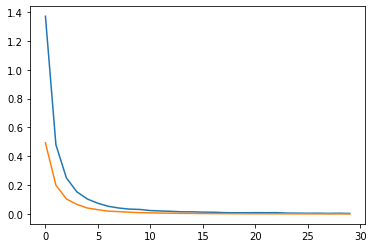

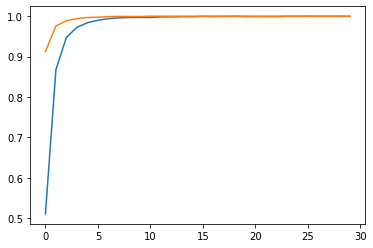

In [3]:
# Start training or inferencing

y_train1=np_utils.to_categorical(y_train,nb_classes)
y_val1=np_utils.to_categorical(y_val,nb_classes)

output_folder = "out_"+type_backbone

if flag_train == True:
    checkpoint_path = "training/"+type_backbone+"/cp_{epoch:04d}.hdf5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        verbose = 1,
        save_weights_only = True,
        period = 10)#Save the weights per 10 epochs
    
    model.save_weights(checkpoint_path.format(epoch=0))
    
    history = model.fit(
        x_train,
        y_train1,
        epochs=30, 
        callbacks = [cp_callback],
        batch_size=32,
        validation_data=(x_val,y_val1))

    score=model.evaluate(x_val,y_val1,verbose=0)
    print("val loss : ",score[0])
    print("val acc : ",score[1])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.savefig(output_folder+"/out_graph/graph_loss.png")
    plt.show()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.savefig(output_folder+"/out_graph/graph_acc.png")
    plt.show()
elif flag_train == False:
    weights_folder_path = "training/"+type_backbone+"/"
    files = os.listdir(weights_folder_path)
    best_weights_path = max(files)# use the last weights
    best_weights_path = "training/"+type_backbone+"/" + best_weights_path 
    print(best_weights_path)
    model.load_weights(best_weights_path)
    print("loaded weights")

In [9]:
#pip install --upgrade scikit-image
#pip install --upgrade numpy
import skimage as skimage
from skimage import transform, color, exposure
from skimage.transform import rotate
from skimage.viewer import ImageViewer


def Grad_Cam(model, x, layer_name):
    print("May update in the future")
    prin("This time, no program")
    return x


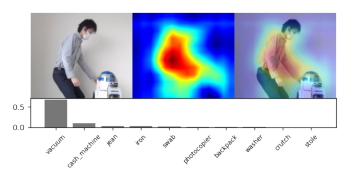

['conv1', 'conv_dw_1', 'conv_pw_1', 'conv_dw_2', 'conv_pw_2', 'conv_dw_3', 'conv_pw_3', 'conv_dw_4', 'conv_pw_4', 'conv_dw_5', 'conv_pw_5', 'conv_dw_6', 'conv_pw_6', 'conv_dw_7', 'conv_pw_7', 'conv_dw_8', 'conv_pw_8', 'conv_dw_9', 'conv_pw_9', 'conv_dw_10', 'conv_pw_10', 'conv_dw_11', 'conv_pw_11', 'conv_dw_12', 'conv_pw_12', 'conv_dw_13', 'conv_pw_13']


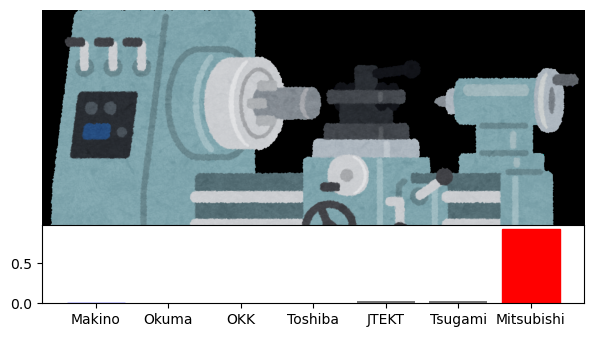

In [17]:
# Inference test images
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

names_conv = [l.name for l in model.layers
                      if isinstance(l, keras.layers.Conv2D)]
print(names_conv)


files_test = glob.glob("test/*")#file name should be like "1_0001.jpg"
k = 1
for i in files_test:
    img_test = load_img(i, target_size=(img_h, img_w))
    true_label = i.strip("test")[1]
    
    array_test = img_to_array(img_test) / 255
    input_test = []
    input_test.append(array_test)
    input_tests = np.array(input_test)
    plobs_pred = model.predict(input_tests)# inference

    pred_classes = np.argmax(plobs_pred, axis = 1)
    x = np.array(input_tests)

    num_tests = len(files_test)

    test_img = cv2.imread(i)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

    fig = plt.figure(figsize = (7,4), dpi= 100)

    gs_master = GridSpec(nrows = 2, ncols = 1, height_ratios = (2.5,1))
    gs = [0]*2
    gs[0] = GridSpecFromSubplotSpec(nrows = 1, ncols = 1, subplot_spec = gs_master[0:2, 0:2])
    gs[1] = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, subplot_spec = gs_master[1, 0])
    ax = [0]*2
    for j in range(len(gs)):
        ax[j] = fig.add_subplot(gs[j][:,:])

    ax[0].imshow(np.asarray(test_img))
    ax[0].axis('off')

    predictions_array, true_label =  plobs_pred[0], int(true_label)-1
    predicted_label = np.argmax(predictions_array)
    thisplot = ax[1].bar(categories, predictions_array, color="#777777")
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    plt.savefig(output_folder+"/out_all/"+str(k) + 'figure.png')
    plt.show()
    
    k += 1


In [3]:

#from PIL import Image
#im = Image.open('test_img_gradcam.png')
#im_list = np.asarray(im)
#plt.axis('off')
#plt.imshow(im_list)
#plt.show()